In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from multiprocessing import Process, Pipe
import argparse
import gym

ModuleNotFoundError: No module named 'torch'

In [1]:
import gym

envs = gym.envs.registry.keys()
print(envs)

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4'])


In [3]:
class ActorCritic(nn.Module):
    ''' A2C网络模型，包含一个Actor和Critic
    '''
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

In [4]:
class A2C:
    def __init__(self,n_states,n_actions,cfg) -> None:
        self.gamma = cfg.gamma
        self.device = cfg.device
        self.model = ActorCritic(n_states, n_actions, cfg.hidden_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters())

    def compute_returns(self,next_value, rewards, masks):
        R = next_value
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.gamma * R * masks[step]
            returns.insert(0, R)
        return returns

In [5]:
import math

class Sinusoidalposemb(nn.model):
    def __init__(self, tdim):
        super(Sinusoidalposemb, self).__init__()
        self.dim = tdim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device = device) * - emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim = -1)
        return emb


class MLP(nn.model):
    def __init__(self, state_dim, action_dim, hidden_dim, device, t_dim):
        super(MLP, self).__init__()

        self.t_dim = t_dim
        self.action_dim = action_dim
        self.divice = device
        
        self.time_mlp = nn.Sequential(
            Sinusoidalposemb(t_dim),
            nn.Linear(t_dim, t_dim*2),
            nn.Mish(),
            nn.Linear(t_dim*2, t_dim)
        )
        
        input_dim = state_dim + action_dim + t_dim
        pass
    
class Diffusion(nn.Module):
    def __init__(self, loss_type, beta_schedule = "linear", clip_denoise = True, **kwargs)
        super(Diffusion, self).__init__()
        
        self.state_dim = kwargs['state_dim']
        self.action_dim = kwargs['action_dim']
        self.hidden_dim = kwargs['hidden_dim']
        self.T = kwargs['T']
        
        if beta_schedule == "linear":
            beta = torch.linspace(0.0001, 0.02, self.T)
        alpha = 1 - beta
        alphas_cumprod = torch.cumprod(alpha, axis = 0)
        alphas_cumprod_pre = torch.cat([torch.ones(1), alphas_cumprod[:-1]])
        
        self.register_buffer("beta", beta)
        self.register_buffer("alpha", alpha)
        self.alphas_cumprod("alphas_cumprod", alphas_cumprod)
        self.alphas_cumprod_pre("alphas_cumprod_pre", alphas_cumprod_pre)
        
        

In [4]:
import torch
alpha = torch.tensor([1,2,3,4])
alphas_cumprod = torch.cumprod(alpha, axis = 0)
alphas_cumprod_pre = torch.cat([torch.ones(1), alphas_cumprod[:-1]])
print(alphas_cumprod)
print(alphas_cumprod_pre)

tensor([ 1,  2,  6, 24])
tensor([1., 1., 2., 6.])


In [9]:
print(alpha[0:4])

tensor([1, 2, 3, 4])


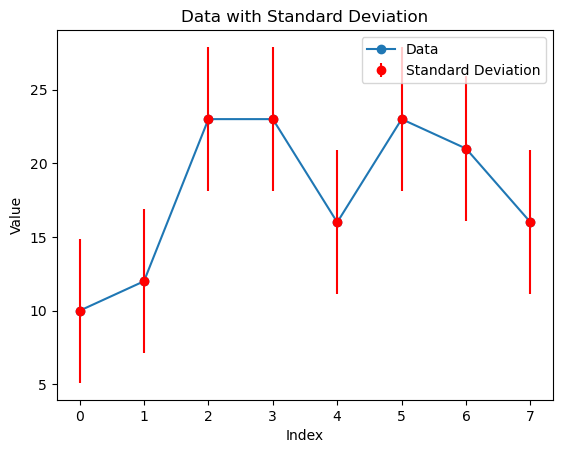

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你有一些数据
data = [10, 12, 23, 23, 16, 23, 21, 16]

# 计算均值和标准差
mean = np.mean(data)
std_dev = np.std(data)

# 创建x轴数据
x = np.arange(len(data))

# 绘制数据点
plt.plot(x, data, 'o-', label='Data')

# 绘制误差棒
plt.errorbar(x, data, yerr=std_dev, fmt='o', label='Standard Deviation', color='red')

# 添加标题和标签
plt.title('Data with Standard Deviation')
plt.xlabel('Index')
plt.ylabel('Value')

# 显示图例
plt.legend()

# 显示图表
plt.show()